### Notebooks based on Kaggle notebook
https://www.kaggle.com/code/matthewkoltunov/house-prices-eda-preprocessing-and-modeling/notebook


In [3]:
!pip3 install numpy --upgrade
!pip3 install pandas --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 38.7 MB/s eta 0:00:0000:010:01
  Attempting uninstall: pandas
    Found existing installation: pandas 1.0.1
    Uninstalling pandas-1.0.1:
      Successfully uninstalled pandas-1.0.1


In [19]:
# import python libraries                                   
import os     

# data analysis
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# sklearn utilities
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

# prediction
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput

In [20]:
# initialize hyperparameters
hyperparameters = {
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"4",
        "min_child_weight":"6",
        "subsample":"0.7",
        "objective":"reg:squarederror",
        "num_round":"50"}

# set an output path where the trained model will be saved
bucket = 'lawsnic-east1'
prefix = 'kaggle/house-prices-advanced-regression-techniques' 
output_path = 's3://{}/{}/{}/output'.format(bucket, prefix, 'abalone-xgb-built-in-algo')

# this line automatically looks for the XGBoost image URI and builds an XGBoost container.
# specify the repo_version depending on your preference.
xgboost_container = sagemaker.image_uris.retrieve("xgboost", "us-east-2", "1.5-1")

# construct a SageMaker estimator that calls the xgboost-container
estimator = sagemaker.estimator.Estimator(image_uri=xgboost_container, 
                                          hyperparameters=hyperparameters,
                                          role=sagemaker.get_execution_role(),
                                          instance_count=1, 
                                          instance_type='ml.m5.2xlarge', 
                                          volume_size=5, # 5 GB 
                                          output_path=output_path)

train_data = pd.read_csv("./train.csv")
test_data = pd.read_csv("./test.csv")

pd.options.display.max_columns = train_data.shape[1]

In [21]:
train_data.shape

(1460, 81)

In [22]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,"2,003.00",RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,"1,976.00",RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,"2,001.00",RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.00,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,"1,998.00",Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,"2,000.00",RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [30]:
test_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.00,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.00,TA,TA,CBlock,TA,TA,No,Rec,468.00,LwQ,144.00,270.00,882.00,GasA,TA,Y,SBrkr,896,0,0,896,0.00,0.00,1,0,2,1,TA,5,Typ,0,NaN,Attchd,"1,961.00",Unf,1.00,730.00,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.00,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.00,TA,TA,CBlock,TA,TA,No,ALQ,923.00,Unf,0.00,406.00,"1,329.00",GasA,TA,Y,SBrkr,1329,0,0,1329,0.00,0.00,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,"1,958.00",Unf,1.00,312.00,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.00,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.00,TA,TA,PConc,Gd,TA,No,GLQ,791.00,Unf,0.00,137.00,928.00,GasA,Gd,Y,SBrkr,928,701,0,1629,0.00,0.00,2,1,3,1,TA,6,Typ,1,TA,Attchd,"1,997.00",Fin,2.00,482.00,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.00,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.00,TA,TA,PConc,TA,TA,No,GLQ,602.00,Unf,0.00,324.00,926.00,GasA,Ex,Y,SBrkr,926,678,0,1604,0.00,0.00,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,"1,998.00",Fin,2.00,470.00,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.00,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.00,Gd,TA,PConc,Gd,TA,No,ALQ,263.00,Unf,0.00,"1,017.00","1,280.00",GasA,Ex,Y,SBrkr,1280,0,0,1280,0.00,0.00,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,"1,992.00",RFn,2.00,506.00,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [23]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [24]:
train_data.describe(include = 'all')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,"1,460.00","1,460.00",1460,"1,201.00","1,460.00",1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,"1,460.00","1,460.00","1,460.00","1,460.00",1460,1460,1460,1460,1452,"1,452.00",1460,1460,1460,1423,1423,1422,1423,"1,460.00",1422,"1,460.00","1,460.00","1,460.00",1460,1460,1460,1459,"1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00",1460,"1,460.00",1460,"1,460.00",770,1379,"1,379.00",1379,"1,460.00","1,460.00",1379,1379,1460,"1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00",7,281,54,"1,460.00","1,460.00","1,460.00",1460,1460,"1,460.00"
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,5,3,25,9,8,5,8,NaN,NaN,NaN,NaN,6,8,15,16,4,NaN,4,5,6,4,4,4,6,NaN,6,NaN,NaN,NaN,6,5,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,7,NaN,5,6,NaN,3,NaN,NaN,5,5,3,NaN,NaN,NaN,NaN,NaN,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,None,NaN,TA,TA,PConc,TA,TA,No,Unf,NaN,Unf,NaN,NaN,NaN,GasA,Ex,Y,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,Gd,Attchd,NaN,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,1151,NaN,NaN,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,NaN,NaN,NaN,NaN,1141,1434,515,504,864,NaN,906,1282,647,649,1311,953,430,NaN,1256,NaN,NaN,NaN,1428,741,1365,1334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,735,NaN,1360,NaN,380,870,NaN,605,NaN,NaN,1311,1326,1340,NaN,NaN,NaN,NaN,NaN,NaN,3,157,49,NaN,NaN,NaN,1267,1198,NaN
mean,730.50,56.90,NaN,70.05,"10,516.83",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.10,5.58,"1,971.27","1,984.87",NaN,NaN,NaN,NaN,NaN,103.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,443.64,NaN,46.55,567.24,"1,057.43",NaN,NaN,NaN,NaN,"1,162.63",346.99,5.84,"1,515.46",0.43,0.06,1.57,0.38,2.87,1.05,NaN,6.52,NaN,0.61,NaN,NaN,"1,978.51",NaN,1.77,472.98,NaN,NaN,NaN,94.24,46.66,21.95,3.41,15.06,2.76,NaN,NaN,NaN,43.49,6.32,"2,007.82",NaN,NaN,"180,921.20"
std,421.61,42.30,NaN,24.28,"9,981.26",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.38,1.11,30.20,20.65,NaN,NaN,NaN,NaN,NaN,181.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456.10,NaN,161.32,441.87,438.71,NaN,NaN,NaN,NaN,386.59,436.53,48.62,525.48,0.52,0.24,0.55,0.50,0.82,0.22,NaN,1.63,NaN,0.64,NaN,NaN,24.69,NaN,0.75,213.80,NaN,NaN,NaN,125.34,66.26,61.12,29.32,55.76,40.18,NaN,NaN,NaN,496.12,2.70,1.33,NaN,NaN,"79,442.50"
min,1.00,20.00,NaN,21.00,"1,300.00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,1.00,"1,872.00","1,950.00",NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,0.00,0.00,0.00,NaN,NaN,NaN,NaN,334.00,0.00,0.00,334.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,2.00,NaN,0.00,NaN,NaN,"1,900.00",NaN,0.00,0.00,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,0.00,1.00,"2,006.00",NaN,NaN,"34,900.00"
25%,365.75,20.00,NaN,59.00,"7,553.50",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.00,5.00,"1,954.00","1,967.00",NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,0.00,223.00,795.75,NaN,NaN,NaN,NaN,882.00,0.00,0.00,"1,129.50",0.00,0.00,1.00,0.00,2.00,1.00,NaN,5.00,NaN,0.00,NaN,

In [25]:
train_data = train_data.drop(columns=['Id'])
test_data = test_data.drop(columns=['Id'])

train_data_num = train_data.select_dtypes(exclude=['object'])
test_data_num = test_data.select_dtypes(exclude=['object'])
train_data_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.00,8450,7,5,2003,2003,196.00,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,"2,003.00",2,548,0,61,0,0,0,0,0,2,2008,208500
1,20,80.00,9600,6,8,1976,1976,0.00,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,"1,976.00",2,460,298,0,0,0,0,0,0,5,2007,181500
2,60,68.00,11250,7,5,2001,2002,162.00,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,"2,001.00",2,608,0,42,0,0,0,0,0,9,2008,223500
3,70,60.00,9550,7,5,1915,1970,0.00,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,"1,998.00",3,642,0,35,272,0,0,0,0,2,2006,140000
4,60,84.00,14260,8,5,2000,2000,350.00,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,"2,000.00",3,836,192,84,0,0,0,0,0,12,2008,250000


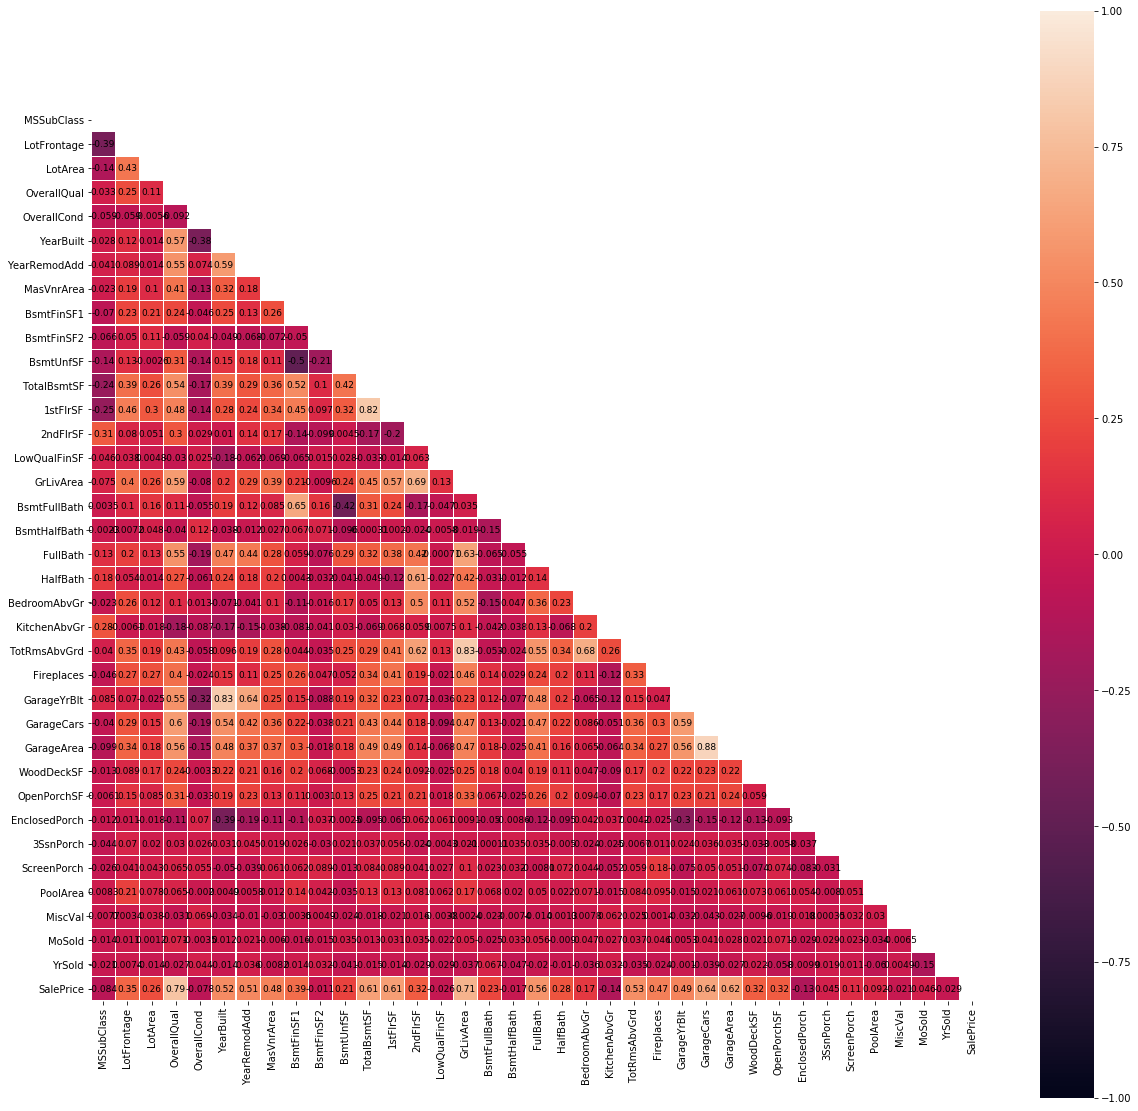

In [26]:
pd.options.display.float_format = "{:,.2f}".format

corr_mat = train_data.corr('pearson')

# define triangular mask for better visibility
mask = np.triu(np.ones_like(corr_mat, dtype=bool))
plt.figure(figsize=(20, 20))
sns.heatmap(corr_mat, mask=mask, vmax=1.0, vmin=-1.0, square=True, annot=True, annot_kws={"size": 9, "color": "black"}, linewidths=0.1, cmap='rocket');

In [15]:
# replace very weak correlation
corr_mat[(corr_mat < 0.3) & (corr_mat > -0.3)] = 0

corr_features = corr_mat['SalePrice'].drop(['SalePrice'])
corr_features.sort_values(ascending=False)

OverallQual     0.79
GrLivArea       0.71
GarageCars      0.64
GarageArea      0.62
TotalBsmtSF     0.61
1stFlrSF        0.61
FullBath        0.56
TotRmsAbvGrd    0.53
YearBuilt       0.52
YearRemodAdd    0.51
GarageYrBlt     0.49
MasVnrArea      0.48
Fireplaces      0.47
BsmtFinSF1      0.39
LotFrontage     0.35
WoodDeckSF      0.32
2ndFlrSF        0.32
OpenPorchSF     0.32
ScreenPorch     0.00
3SsnPorch       0.00
PoolArea        0.00
EnclosedPorch   0.00
MiscVal         0.00
MoSold          0.00
Id              0.00
BsmtHalfBath    0.00
KitchenAbvGr    0.00
BedroomAbvGr    0.00
HalfBath        0.00
MSSubClass      0.00
BsmtFullBath    0.00
LowQualFinSF    0.00
BsmtUnfSF       0.00
BsmtFinSF2      0.00
OverallCond     0.00
LotArea         0.00
YrSold          0.00
Name: SalePrice, dtype: float64

## Now we combine test and train data to fix missing data in the input files

In [29]:
# Separating Target and Features

target = train_data['SalePrice']
test_id = test_data['Id']
test = test_data.drop(['Id'],axis = 1)
data_w2 = train_data.drop(['SalePrice','Order','PID'], axis = 1)


# Concatenating train & test set

train_test = pd.concat([train_data,test_data], axis=0, sort=False)

KeyError: 'Id'

In [16]:
#train_data = train_data.drop(columns=['Id','PoolQC', 'MiscFeature', '2ndFlrSF','FireplaceQu','YearBuilt','GarageCars'])
#test_data = test_data.drop(columns=['Id','PoolQC', 'MiscFeature', '2ndFlrSF','FireplaceQu','YearBuilt','GarageCars'])

In [ ]:
#train_data['MSSubClass'] = ((train_data['MSSubClass'].astype(int)/10)+65).apply(int).apply(chr)
#test_data['MSSubClass'] = ((test_data['MSSubClass'].astype(int)/10)+65).apply(int).apply(chr)

In [ ]:
#train_data_cat = train_data.select_dtypes(include=['object'])
#test_data_cat = test_data.select_dtypes(include=['object'])
#train_data_cat.head()

In [ ]:
#train_data_num.hist(figsize=(25, 30), bins=30);

In [ ]:
##fig, ax = plt.subplots(1, len(train_data_cat.columns))
#fig, ax = plt.subplots(45,figsize=(30,100))
#for i, categorical_feature in enumerate(train_data_cat):
#    train_data_cat[categorical_feature].value_counts().plot(kind="bar", ax=ax[i]).set_title(categorical_feature)
#    #train_data_cat[categorical_feature].value_counts().plot(subplots=True, kind="bar")
#fig.show()

In [ ]:
selector = VarianceThreshold(threshold=0.05)

selector.fit(train_data_num.iloc[:, :-1])

sup = selector.get_support()

print('Number of retained features: ', sum(sup))

print('Number low-variance features: ', sum(~sup))

low_var_fet = train_data_num.drop(['SalePrice'], axis=1).loc[:, ~sup].columns.values

print('Low-variance features: ', low_var_fet)

print('Before: ',train_data_num.shape, test_data_num.shape)
train_data_num.drop(low_var_fet, axis=1, inplace=True)
test_data_num.drop(low_var_fet, axis=1, inplace=True)
print('After: ', train_data_num.shape, test_data_num.shape)

In [ ]:
corr_features = corr_mat['SalePrice'].drop(['SalePrice'])
corr_features.sort_values(ascending=False)

In [ ]:
chosen_feats = corr_features[(abs(corr_features) >= 0.3)].index.tolist()
#chosen_feats
cleaned_train_data = train_data[['SalePrice'] + chosen_feats]
cleaned_test_data = test_data[chosen_feats]



In [ ]:
splitData_train, splitData_val, splitData_test = np.split(cleaned_train_data.sample(frac=1, random_state=1729), [int(0.7 * len(cleaned_train_data)), int(0.9 * len(cleaned_train_data))])   # Randomly sort the data then split out first 70%, second 20%, and last 10%

splitData_train.to_csv('train/train.csv', index=False, header=False)
splitData_val.to_csv('validation/validation.csv', index=False, header=False)
 
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'input/train/preped/train.csv')).upload_file('train/train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'input/validation/preped/validation.csv')).upload_file('validation/validation.csv')

In [ ]:
sess = sagemaker.Session()
role = get_execution_role()

xgb = sagemaker.estimator.Estimator(
    sagemaker.image_uris.retrieve("xgboost", sess.boto_region_name, "1.5-1"),
    role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sess,
)
xgb.set_hyperparameters(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    verbosity=0,
    objective="binary:logistic",
    num_round=100,
)

In [ ]:
s3_input_train = TrainingInput(    s3_data="s3://{}/{}/input/train/preped/".format(bucket, prefix), content_type="csv")
s3_input_validation = TrainingInput(    s3_data="s3://{}/{}/input/validation/preped/".format(bucket, prefix), content_type="csv")

xgb.fit({"train": s3_input_train, "validation": s3_input_validation})

In [ ]:
os.path.join(prefix, 'train/preped/train.csv')